In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#　訓練データ
import requests
import csv
import os
import pandas as pd
from sklearn.cross_validation import train_test_split

birthdata_url = 'https://raw.githubusercontent.com/nfmcclure/tensorflow_cookbook/master/01_Introduction/07_Working_with_Data_Sources/birthweight_data/birthweight.dat'
birth_file = requests.get(birthdata_url)
birth_data = birth_file.text.split('\r\n')
birth_header = birth_data[0].split('\t')
birth_data = [[float(x) for x in y.split('\t') if len(x) >= 1]  
              for y in birth_data[1:] if len(y) >= 1]

with open("birth_weight.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows([birth_header])
    writer.writerows(birth_data)
    f.close()

def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return np.nan_to_num((m-col_min)/(col_max-col_min))

df = pd.read_csv("birth_weight.csv")
target_name = ["BWT"]
X, y = df[df.columns.drop(target_name)], df[target_name]
X, y = X.as_matrix(), y.as_matrix()
X = normalize_cols(X)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)
print X.shape
print y.shape
print X_train.shape
print y_train.shape

(189, 8)
(189, 1)
(141, 8)
(141, 1)


In [3]:
#　初期化
X = X_train
y = y_train.ravel()
sess = tf.Session()
seed = 3
tf.set_random_seed(seed)
np.random.seed(seed)

x_data = tf.placeholder(shape=[None, X.shape[1]], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

In [4]:
hidden_size = [25, 10, 3]
batch_size = 100
iter_size = 200

#　隠れ層の作成 （last layerに直結）
weights = []
biases = []
layers = []
tmp_size = X.shape[1]
last_layer = x_data
for hsize in hidden_size:
    weights.append(tf.Variable(tf.random_normal(shape=[tmp_size, hsize], stddev=10.0)))
    biases.append(tf.Variable(tf.random_normal(shape=[hsize], stddev=10.0)))
    layers.append(tf.nn.relu(tf.add(tf.matmul(last_layer, weights[-1]), biases[-1]))) # 活性化関数
    tmp_size = hsize
    last_layer = layers[-1]
    print layers[-1]
#　出力層
weights.append(tf.Variable(tf.random_normal(shape=[tmp_size, 1], stddev=10.0)))
biases.append(tf.Variable(tf.random_normal(shape=[1], stddev=10.0)))
layers.append(tf.nn.relu(tf.add(tf.matmul(last_layer, weights[-1]), biases[-1])))
final_output = layers[-1]
print final_output

Tensor("Relu:0", shape=(?, 25), dtype=float32)
Tensor("Relu_1:0", shape=(?, 10), dtype=float32)
Tensor("Relu_2:0", shape=(?, 3), dtype=float32)
Tensor("Relu_3:0", shape=(?, 1), dtype=float32)


In [7]:
#　学習
loss = tf.reduce_mean(tf.abs(y_target - final_output))
opt = tf.train.AdamOptimizer(0.05)
train_step = opt.minimize(loss)
init = tf.global_variables_initializer()
sess.run(init)
loss_vec=[]
for i in range(iter_size):
    rand_index = np.random.choice(len(X), size=batch_size)
    rand_x = X[rand_index]
    rand_y = np.transpose([y[rand_index]])
    sess.run(train_step, feed_dict={x_data:rand_x, y_target: rand_y})
    loss_vec.append(sess.run(loss, feed_dict={x_data:rand_x, y_target: rand_y}))
    if (i+1)%25==0:
        print('Generation:'+str(i+1)+', Loss = '+str(loss_vec[-1]))

Generation:25, Loss = 2947.85
Generation:50, Loss = 2990.98
Generation:75, Loss = 2829.53
Generation:100, Loss = 3122.67
Generation:125, Loss = 2929.67
Generation:150, Loss = 3007.9
Generation:175, Loss = 2945.42
Generation:200, Loss = 2970.72


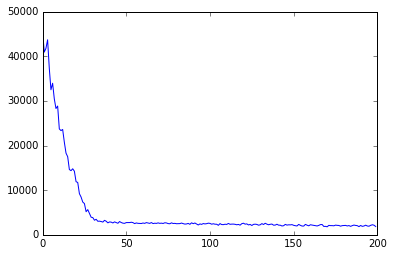

In [6]:
plt.plot(loss_vec)